In [167]:
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
import libpysal
import numpy as np
import pysal
import pandas as pd
#from libpysal.weights.contiguity import Queen
from libpysal.weights import Queen, Rook, KNN, Kernel
from splot.libpysal import plot_spatial_weights

import pickle

from shapely.ops import cascaded_union

In [179]:
pathW = 'maps/Wojewodztwa/Województwa.shp'
# https://github.com/Toblerity/Fiona/issues/548
gdfW = gpd.read_file(pathW) 
for i in range(len(gdfW.JPT_NAZWA_)):
    gdfW.JPT_NAZWA_[i] = gdfW.JPT_NAZWA_[i].encode("latin1","strict").decode('utf-8')
#print(gdf.head())

/home/marek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [190]:
path = 'maps/wojewodztwa/województwa.shp'
# https://github.com/Toblerity/Fiona/issues/548
gdf = gpd.read_file(path) 
for i in range(len(gdf.jpt_nazwa_)):
    gdf.jpt_nazwa_[i] = gdf.jpt_nazwa_[i].encode("latin1","strict").decode('utf-8')
#print(gdf.head())

gdf = pd.merge(gdfW.loc[:,['JPT_NAZWA_']],gdf,left_on='JPT_NAZWA_',right_on='jpt_nazwa_')
del gdf['JPT_NAZWA_']
gdf['jpt_nazwa_']

/home/marek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0                 śląskie
1                opolskie
2           wielkopolskie
3      zachodniopomorskie
4          świętokrzyskie
5      kujawsko-pomorskie
6               podlaskie
7            dolnośląskie
8            podkarpackie
9             małopolskie
10              pomorskie
11    warmińsko-mazurskie
12                łódzkie
13            mazowieckie
14              lubelskie
15               lubuskie
Name: jpt_nazwa_, dtype: object

In [191]:
#weights = Queen.from_dataframe(gdf)
wq = Queen.from_dataframe(gdf)
wq_W = Queen.from_dataframe(gdfW)

(137166.64563126868, 896406.6565342785, 101133.9541251598, 807108.9159854098)

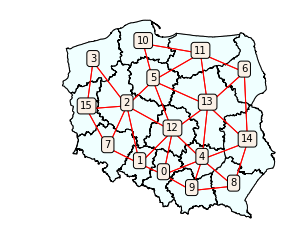

In [192]:
pos_w = {}

woj = gdf
woj['centroid'] = woj['geometry'].centroid

ax = gdf.plot(edgecolor='grey', facecolor='w')
fig, ax = wq.plot(gdf, ax=ax, 
        edge_kws=dict(color='r', linestyle='-', linewidth=1),
        node_kws=dict(marker=''))
#plt.subplots(1, figsize=(50,50))
gdf.plot(color='azure', edgecolor='black', ax=ax)
props = dict(boxstyle='round', facecolor='linen', alpha=1)
for point in woj.iterrows():
    ax.text(point[1]['centroid'].x,
            point[1]['centroid'].y,
            point[0],
            horizontalalignment='center',
            fontsize=10,
            bbox=props)
    pos_w[point[0]] = [point[1]['centroid'].x, point[1]['centroid'].y]

ax.axis('off')

(13.621739949250054, 24.646927985750054, 48.71032801055003, 55.12813517445003)

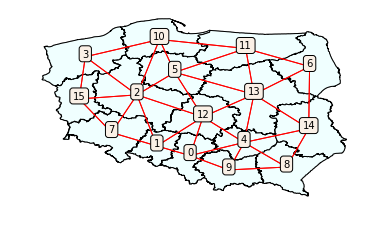

In [193]:
woj = gdfW
woj['centroid'] = woj['geometry'].centroid

ax = gdfW.plot(edgecolor='grey', facecolor='w')
fig, ax = wq_W.plot(gdfW, ax=ax, 
        edge_kws=dict(color='r', linestyle='-', linewidth=1),
        node_kws=dict(marker=''))
#plt.subplots(1, figsize=(50,50))
gdfW.plot(color='azure', edgecolor='black', ax=ax)
props = dict(boxstyle='round', facecolor='linen', alpha=1)
for point in woj.iterrows():
    ax.text(point[1]['centroid'].x,
            point[1]['centroid'].y,
            point[0],
            horizontalalignment='center',
            fontsize=10,
            bbox=props)

ax.axis('off')

In [194]:
contig_matrix = libpysal.weights.Rook.from_shapefile(pathW)

# build list of edges - this will create edges going both ways from connected nodes, so you might need to remove duplicates
nodes = contig_matrix.weights.keys()  # to get dict of keys, alternatively use contig_matrix.id2i.keys()
edges = [(node, neighbour) for node in nodes for neighbour in contig_matrix[node]]
my_graph = nx.Graph(edges)

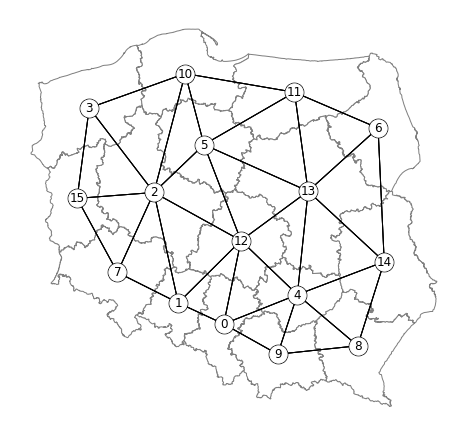

In [216]:
#plot_spatial_weights(weights, gdf, figsize=(8,8))
#ax = gdf.plot(edgecolor='grey', facecolor='w', figsize=(8,8))
#nx.draw(my_graph, pos_w)  
#fig, ax = plt.subplots(figsize=(8, 8))

#gdf.plot(edgecolor='grey', facecolor='w', ax=ax)
#gdf.boundary.plot(ax=ax, color="k")

fig, ax = plt.subplots(figsize=(8, 8))

labels={}
for i in range(len(my_graph)):
    labels[i]=i+1

#nx.draw_networkx_edges(my_graph, pos_w)

gdf.plot(edgecolor='grey', facecolor='w', ax=ax)

nx.draw_networkx_edges(my_graph, pos_w, edge_color="k")

nx.draw(my_graph, pos_w, node_color='black', node_size=350, with_labels=False)
nx.draw(my_graph, pos_w, node_color='white', with_labels=True)

#nx.draw_networkx_labels(my_graph,pos_w,labels,font_size=16)

ax.axis('off')
#plt.show()
plt.savefig('maps/images/poland_wojew_neigh.pdf', bbox_inches='tight')

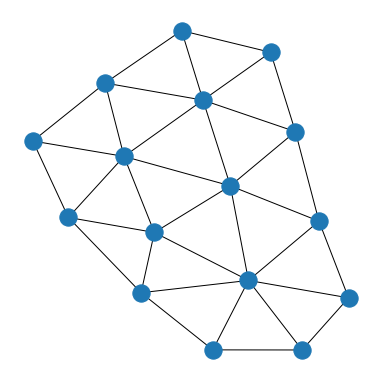

In [217]:
plt.figure(figsize=(5,5))
nx.draw(my_graph)  # networkx draw()
#plt.draw()  # pyplot draw()
plt.show()

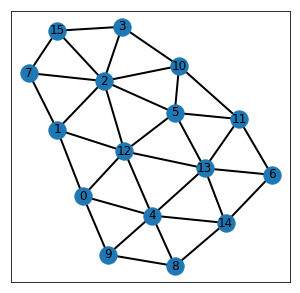

In [219]:
plt.figure(figsize=(5,5))
nx.draw_networkx(my_graph, width=2)
#plt.figure(figsize=(100,100))
plt.draw()  # pyplot draw()
plt.show()

In [220]:
contig_matrix.neighbors

{0: [1, 4, 12, 9],
 1: [0, 2, 12, 7],
 2: [1, 3, 5, 7, 10, 12, 15],
 3: [2, 10, 15],
 4: [0, 8, 9, 12, 13, 14],
 5: [2, 10, 11, 12, 13],
 6: [11, 13, 14],
 7: [1, 2, 15],
 8: [9, 4, 14],
 9: [0, 8, 4],
 10: [11, 2, 3, 5],
 11: [10, 13, 5, 6],
 12: [0, 1, 2, 4, 5, 13],
 13: [4, 5, 6, 11, 12, 14],
 14: [8, 4, 13, 6],
 15: [2, 3, 7]}

In [222]:
wojew = {}
for node in contig_matrix.neighbors:
    tmp_list = []
    for neigh in contig_matrix.neighbors[node]:
        tmp_list.append( gdfW.loc[neigh,'JPT_NAZWA_'] )
    wojew[gdfW.loc[node,'JPT_NAZWA_']] = tmp_list
wojew

{'śląskie': ['opolskie', 'świętokrzyskie', 'łódzkie', 'małopolskie'],
 'opolskie': ['śląskie', 'wielkopolskie', 'łódzkie', 'dolnośląskie'],
 'wielkopolskie': ['opolskie',
  'zachodniopomorskie',
  'kujawsko-pomorskie',
  'dolnośląskie',
  'pomorskie',
  'łódzkie',
  'lubuskie'],
 'zachodniopomorskie': ['wielkopolskie', 'pomorskie', 'lubuskie'],
 'świętokrzyskie': ['śląskie',
  'podkarpackie',
  'małopolskie',
  'łódzkie',
  'mazowieckie',
  'lubelskie'],
 'kujawsko-pomorskie': ['wielkopolskie',
  'pomorskie',
  'warmińsko-mazurskie',
  'łódzkie',
  'mazowieckie'],
 'podlaskie': ['warmińsko-mazurskie', 'mazowieckie', 'lubelskie'],
 'dolnośląskie': ['opolskie', 'wielkopolskie', 'lubuskie'],
 'podkarpackie': ['małopolskie', 'świętokrzyskie', 'lubelskie'],
 'małopolskie': ['śląskie', 'podkarpackie', 'świętokrzyskie'],
 'pomorskie': ['warmińsko-mazurskie',
  'wielkopolskie',
  'zachodniopomorskie',
  'kujawsko-pomorskie'],
 'warmińsko-mazurskie': ['pomorskie',
  'mazowieckie',
  'kujawsko-p

In [223]:
a_file = open("wojew_neighbours.pkl", "wb")

pickle.dump(wojew, a_file)

a_file.close()

In [1]:
#get the length of borders

In [ ]:
# get the geometry of the places of interest
namerica = continents3857.geometry[3]   # north-america
samerica = continents3857.geometry[5]   # south-america

# get intersection between N and S America continents
na_intersect_sa = namerica.intersection(samerica)   # got multi-line

# show the length of the result (multi-line object)
blength = na_intersect_sa.length   # unit is meters on Spherical Mercator
print("Length in meters:", "%d" % blength)